In [ ]:
import pandas as pd
import numpy as np


def PrepX(X:pd.DataFrame):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    new_cols = []
    for col, t in X_types.items():

        #Leaves numeric columns unchanged, no scaling needed for tree-based methods, scale invariant
        if t in ['int', 'float']: 
            new_cols.append(X[col].copy())
            continue

        #Create dummies for categorical (str) columns
        if t == 'object': 
            new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    return X_prep

#Split data into train and validation set. 
def Split(X:pd.DataFrame, Y:pd.DataFrame, TestSize:float, random_state:int=42):

    split_index = np.random.RandomState(random_state) \
                           .choice([True, False], size=len(Y), p=[TestSize,1-TestSize])
    
    X_test = X[split_index]
    X_train = X[~split_index]
    Y_test = Y[split_index]
    Y_train = Y[~split_index]

    return X_test, X_train, Y_test, Y_train



with open('../../data/DatasetCleaned.csv', 'r') as f:
    DATA = pd.read_csv(f)


Y_DATA = np.log(DATA['SalePrice'].copy().values)
VAR_DEPENDENT = 'SalePrice'

X_DATA = DATA.copy().drop(columns=['SalePrice','Unnamed: 0'])
X_DATA = PrepX(X_DATA)
VAR_NAMES = X_DATA.columns

VALIDATION_SET = True
if VALIDATION_SET: 
    X_VAL, X_DATA, Y_VAL, Y_DATA = Split(X_DATA, Y_DATA, 0.05, 1)
    X_VAL = X_VAL.values.reshape(-1, X_VAL.shape[1])

X_DATA = X_DATA.values.reshape(-1,X_DATA.shape[1])

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

from tqdm.notebook import tqdm

def SingleTree_Pruning(X=X_DATA, Y=Y_DATA, min_leaf_samples:int=5, **kwargs):

    TreeModel = DecisionTreeRegressor(min_samples_leaf=min_leaf_samples)

    CCP_PATH = TreeModel.cost_complexity_pruning_path(X_DATA, Y_DATA)
    ccp_alphas = CCP_PATH.ccp_alphas

    PrunedTrees = []
    for ccp_alpha in tqdm(ccp_alphas, desc='Generating Pruned Trees', unit='Tree'):
        PrunedTree = DecisionTreeRegressor(min_samples_leaf=min_leaf_samples, ccp_alpha=ccp_alpha, **kwargs)
        PrunedTree.fit(X_DATA, Y_DATA)
        TrainError = np.mean( (Y_DATA - PrunedTree.predict(X_DATA))**2 )
        TestError = np.mean( -cross_val_score(PrunedTree, X_DATA, Y_DATA, scoring="neg_mean_squared_error", cv=KFold(), n_jobs=1) )
        PrunedTrees.append({'Tree':PrunedTree, 'alpha':ccp_alpha, 'tree_size':PrunedTree.tree_.node_count - PrunedTree.tree_.n_leaves,
                            'TrainError':TrainError, 'TestError':TestError})
    PrunedTrees = pd.DataFrame(PrunedTrees)

    return PrunedTrees

Generating Pruned Trees:   0%|          | 0/180 [00:00<?, ?Tree/s]

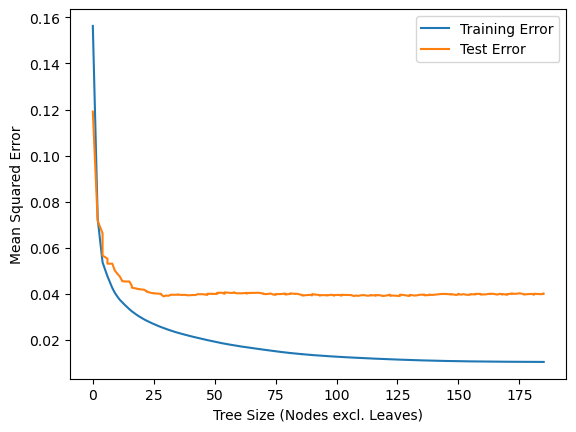

In [ ]:
import matplotlib.pyplot as plt

PrunedTrees = SingleTree_Pruning(min_leaf_samples=5)

plt.plot(PrunedTrees['tree_size'], PrunedTrees['TrainError'], label='Training Error')
plt.plot(PrunedTrees['tree_size'], PrunedTrees['TestError'], label = 'Test Error')
plt.xlabel('Tree Size (Nodes excl. Leaves)')
plt.ylabel('Mean Squared Error')
plt.legend()